### Import Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, mean_absolute_error, brier_score_loss
from xgboost import XGBRegressor

import tensorflow as tf

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

### Load Dataset


In [2]:
path = 'data2/**'
data = {p.split('\\')[-1].split('.')[0] : pd.read_csv(p, encoding='latin-1') for p in glob.glob(path)}

season_cresults = pd.concat([data['MRegularSeasonCompactResults'], data['WRegularSeasonCompactResults']])
season_dresults = pd.concat([data['MRegularSeasonDetailedResults'], data['WRegularSeasonDetailedResults']])
tourney_dresults = pd.concat([data['MNCAATourneyDetailedResults'], data['WNCAATourneyDetailedResults']])
tourney_cresults = pd.concat([data['MNCAATourneyCompactResults'], data['WNCAATourneyCompactResults']])
slots = pd.concat([data['MNCAATourneySlots'], data['WNCAATourneySlots']])
seeds = pd.concat([data['MNCAATourneySeeds'], data['WNCAATourneySeeds']])
seeds_dict = {'_'.join(map(str,[int(k1),k2])):int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}
# gcities = pd.concat([data['MGameCities'], data['WGameCities']])
seasons = pd.concat([data['MSeasons'], data['WSeasons']])

### Data Analysis


- MNCAATourneyCompactResults has more features than MNCAATourneyDetailedResults; Only MNCAATourneyDetailedResults will be used in the analysis
- Team seeds and tournament detailed results are the main dataset used in the analysis

### Feature Engineering

In [3]:
# Map the season, team ID and seed into dictionary
# This will be helpful to map the team seed based on the team ID
seeds = {'_'.join(map(str,[int(k1),k2])):int(v[1:3]) for k1, v, k2 in seeds[['Season', 'Seed', 'TeamID']].values}

#This is the format required for the Kaggle Competition Submission
sub = data['SampleSubmissionStage2']
del data

#Encode the season and tourney results into 0 and 1 respectively 
season_cresults['ST'] = 0
season_dresults['ST'] = 0
tourney_cresults['ST'] = 1
tourney_dresults['ST'] = 1

games = pd.concat((season_dresults, tourney_dresults), axis=0, ignore_index=True)
games.reset_index(drop=True, inplace=True)
#games

In [4]:
#Generate team ID based on the format Season_LowerIDTeam_HigherIDTeam as required by the Kaggle Competition
games['ID'] = games.apply(lambda r: '_'.join(map(str, [r['Season']]+sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
games['IDTeams'] = games.apply(lambda r: '_'.join(map(str, sorted([r['WTeamID'],r['LTeamID']]))), axis=1)
games['Team1'] = games.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[0], axis=1)
games['Team2'] = games.apply(lambda r: sorted([r['WTeamID'],r['LTeamID']])[1], axis=1)
games['IDTeam1'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
games['IDTeam2'] = games.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)

#Map the team seed to the team ID
games['Team1Seed'] = games['IDTeam1'].map(seeds).fillna(0)
games['Team2Seed'] = games['IDTeam2'].map(seeds).fillna(0)

games['ScoreDiff'] = games['WScore'] - games['LScore']

#Estimate the game outcome based on the team ID format
games['Pred'] = games.apply(lambda r: 1. if sorted([r['WTeamID'],r['LTeamID']])[0]==r['WTeamID'] else 0., axis=1)
games['ScoreDiffNorm'] = games.apply(lambda r: r['ScoreDiff'] * -1 if r['Pred'] == 0. else r['ScoreDiff'], axis=1)
games['SeedDiff'] = games['Team1Seed'] - games['Team2Seed'] 

#Encode the game location, home, away and neutral 
games =pd.get_dummies(games,columns=['WLoc'])

#Only Tournament Data is analysed to be able to anlayse multiple models 
games = games[games['ST']==1]


In [5]:
#list of all parameters that will be specific between two teams. 
c_score_col = ['NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl',
 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl',
 'LBlk', 'LPF']
#The score is aggregated based on the following metrics. 
c_score_agg = ['sum', 'mean', 'median', 'max', 'min', 'std', 'skew', 'nunique']
#The score is estimated for each IDTeams
gb = games.groupby(by=['IDTeams']).agg({k: c_score_agg for k in c_score_col}).reset_index()
gb.columns = [''.join(c) + '_c_score' for c in gb.columns]
#gb

In [6]:
#Similar analysis that was done for the games done for the 2025 games submission format. 
sub['WLoc_A'] = False
sub['WLoc_H'] = False
sub['WLoc_N'] = True
sub['Season'] = sub['ID'].map(lambda x: x.split('_')[0])
sub['Season'] = sub['Season'].astype(int)
sub['Team1'] = sub['ID'].map(lambda x: x.split('_')[1])
sub['Team2'] = sub['ID'].map(lambda x: x.split('_')[2])
sub['IDTeams'] = sub.apply(lambda r: '_'.join(map(str, [r['Team1'], r['Team2']])), axis=1)
sub['IDTeam1'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team1']])), axis=1)
sub['IDTeam2'] = sub.apply(lambda r: '_'.join(map(str, [r['Season'], r['Team2']])), axis=1)
sub['Team1Seed'] = sub['IDTeam1'].map(seeds).fillna(0)
sub['Team2Seed'] = sub['IDTeam2'].map(seeds).fillna(0)

sub['Team1Seed'] = sub['IDTeam1'].map(seeds)
sub['Team2Seed'] = sub['IDTeam2'].map(seeds)

sub['SeedDiff'] = sub['Team1Seed'] - sub['Team2Seed']
#sub

In [7]:
#Merge the games and sub with the feature engineered scores for different IDTeams
games = pd.merge(games, gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')
sub = pd.merge(sub, gb, how='left', left_on='IDTeams', right_on='IDTeams_c_score')

sub = sub.drop(['IDTeams_c_score'], axis = 1)
games = games.drop(['IDTeams_c_score'], axis = 1)

#Select the unique columns that will be used to build models. 
col = [c for c in games.columns if c not in ['ID', 'DayNum', 'ST', 'Team1', 'Team2', 'IDTeams', 'IDTeam1', 'IDTeam2', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'NumOT', 'Pred','ScoreDiff', 'ScoreDiffNorm', 'WLoc'] + c_score_col]

### Data Analysis

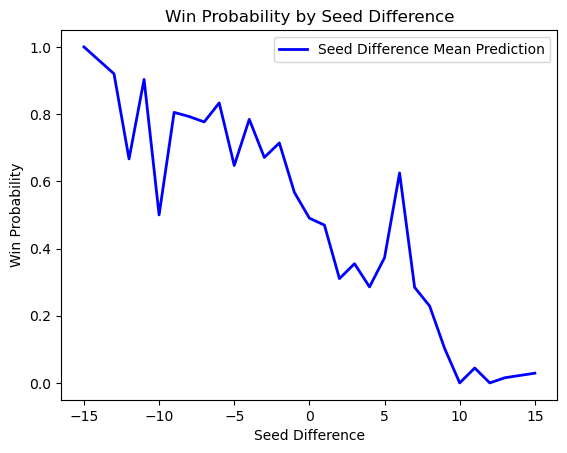

In [8]:
# Plot Win Probability by Seed Difference
seed_prob = games.groupby('SeedDiff', as_index=False)['Pred'].mean()
seed_prob.plot(x='SeedDiff', y='Pred', label = 'Seed Difference Mean Prediction', color='blue', lw=2)# seed_df
seed_df = pd.DataFrame({'SeedDiff': pd.Series(range(-15, 16))})
plt.xlabel("Seed Difference")
plt.ylabel("Win Probability")
plt.title("Win Probability by Seed Difference")
plt.show()


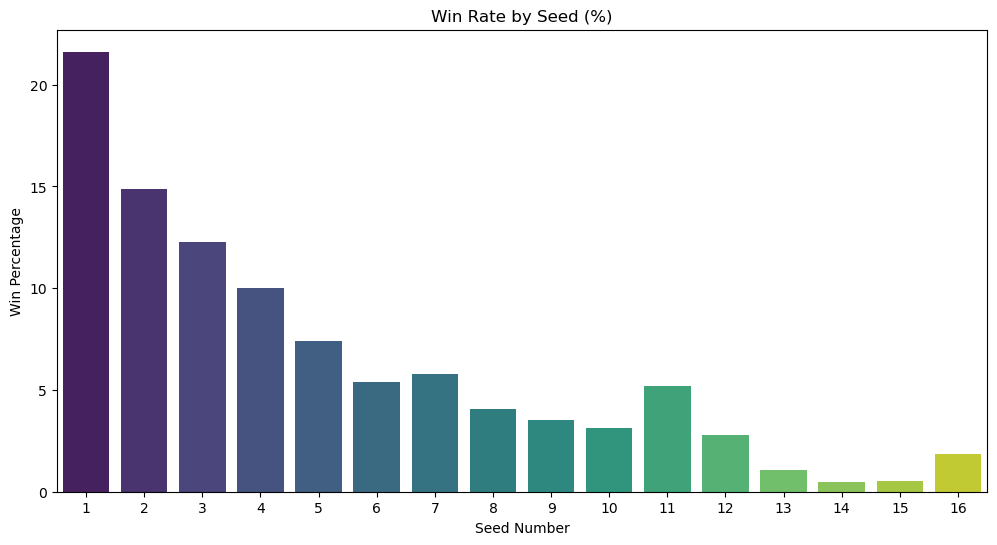

In [9]:
tourney_dresults['WSeed'] = tourney_dresults.apply(lambda r: seeds_dict.get(f"{r['Season']}_{r['WTeamID']}", np.nan), axis=1)
# tourney_dresults['LSeed'] = tourney_dresults.apply(lambda r: seeds_dict.get(f"{r['Season']}_{r['LTeamID']}", np.nan), axis=1)
seed_win_rate = tourney_dresults.groupby('WSeed').size() / tourney_dresults.groupby('WSeed').size().sum() * 100
plt.figure(figsize=(12, 6))
sns.barplot(x=seed_win_rate.index, y=seed_win_rate.values, palette="viridis")
plt.title("Win Rate by Seed (%)")
plt.xlabel("Seed Number")
plt.ylabel("Win Percentage")
plt.show()

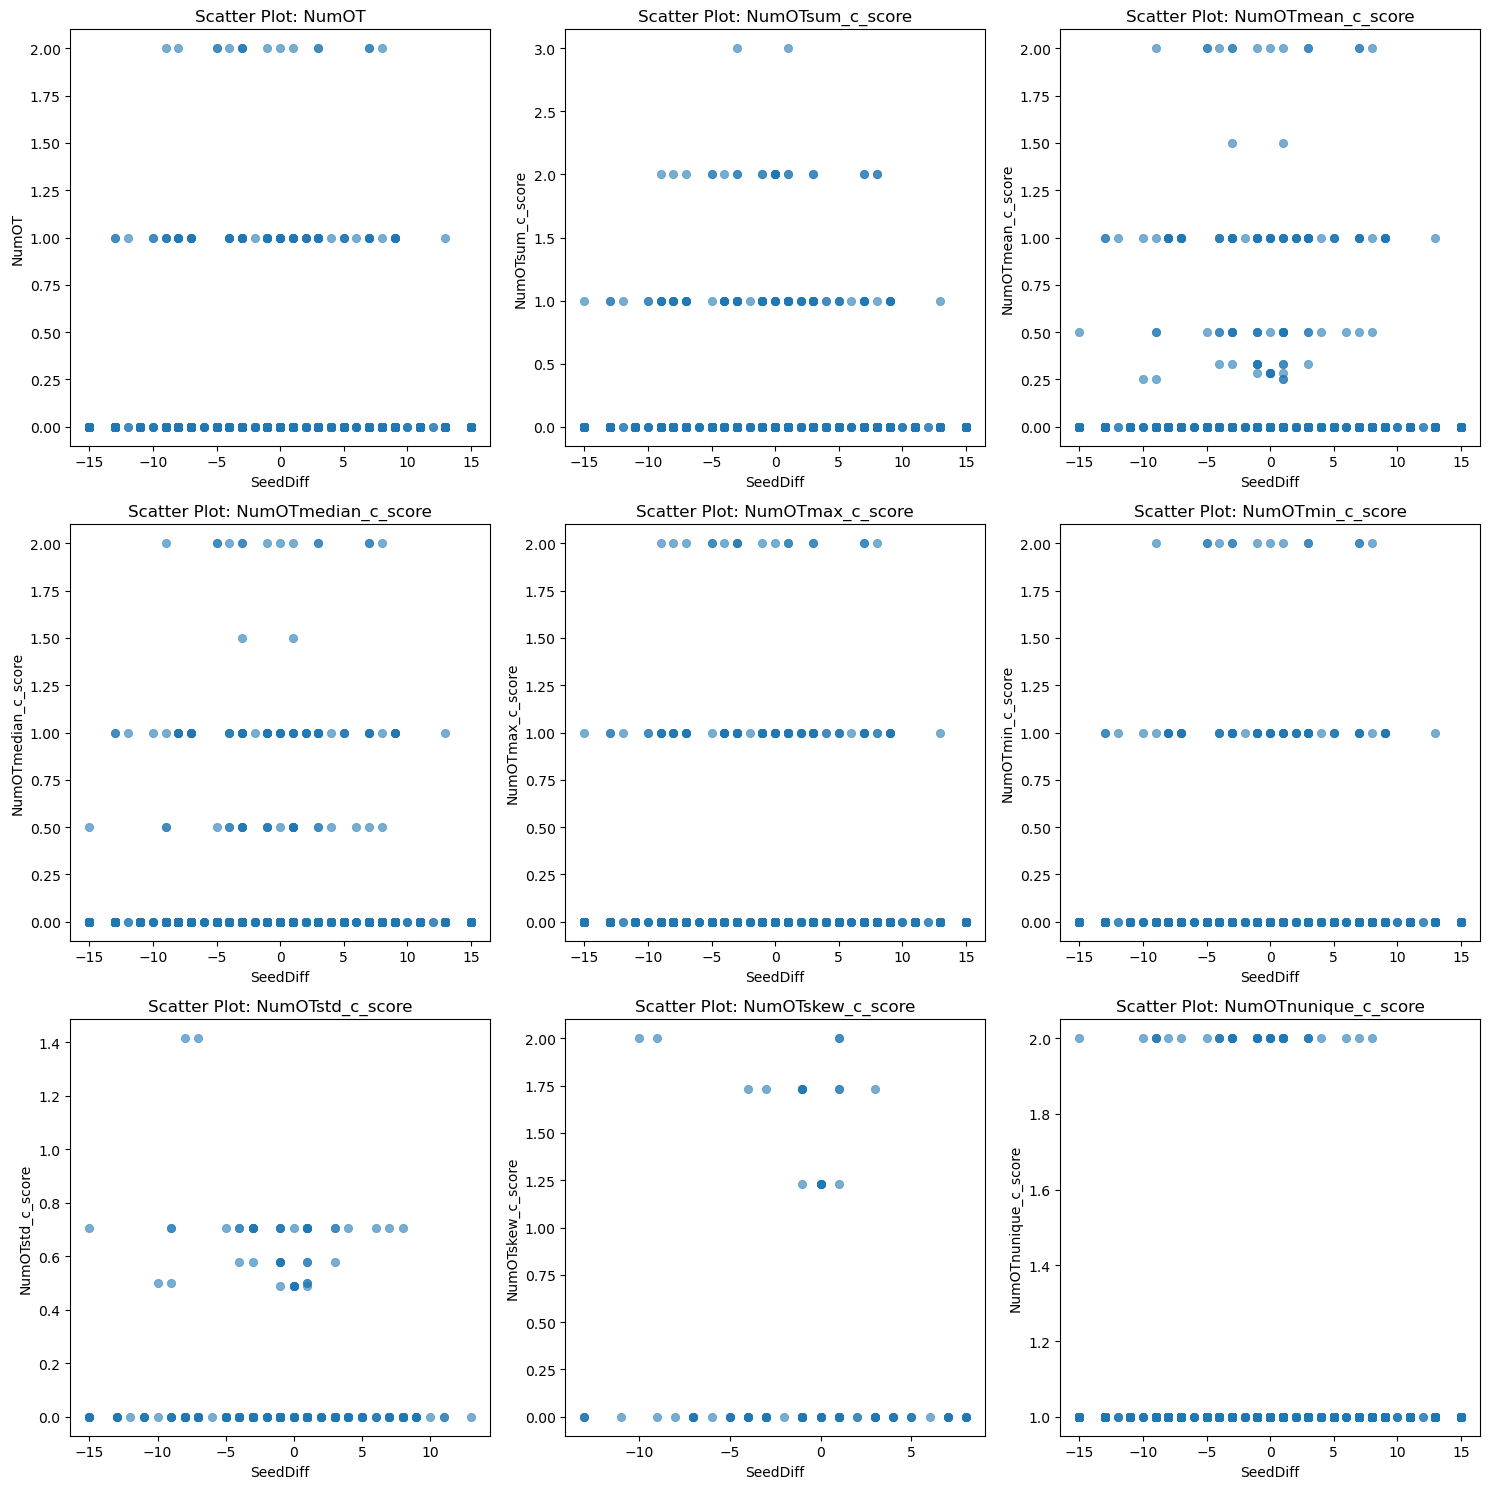

In [10]:
# NumOT feature Engineering: NumOT - this indicates the number of overtime periods in the game, an integer 0 or higher.

colplot = [
    'NumOT', 'NumOTsum_c_score',
    'NumOTmean_c_score', 'NumOTmedian_c_score',
    # Add more columns if needed
    'NumOTmax_c_score', 'NumOTmin_c_score',
    'NumOTstd_c_score', 'NumOTskew_c_score', 'NumOTnunique_c_score'
]

# Number of rows and columns for the grid
rows, cols = 3, 3

# Create a figure and set the size
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 3x3 grid for easy iteration

# Loop through columns and plot
for i, colnum in enumerate(colplot):
    sns.scatterplot(
        x=games['SeedDiff'],
        y=games[colnum],
        alpha=0.6,
        edgecolor=None,
        ax=axes[i]  # Pass the specific subplot to sns.scatterplot
    )
    axes[i].set_title(f"Scatter Plot: {colnum}")
    axes[i].set_xlabel("SeedDiff")
    axes[i].set_ylabel(colnum)

# Turn off empty subplots if colplot has fewer than 9 columns
for i in range(len(colplot), len(axes)):
    axes[i].axis('off')

# Adjust spacing between plots
plt.tight_layout()
plt.show()


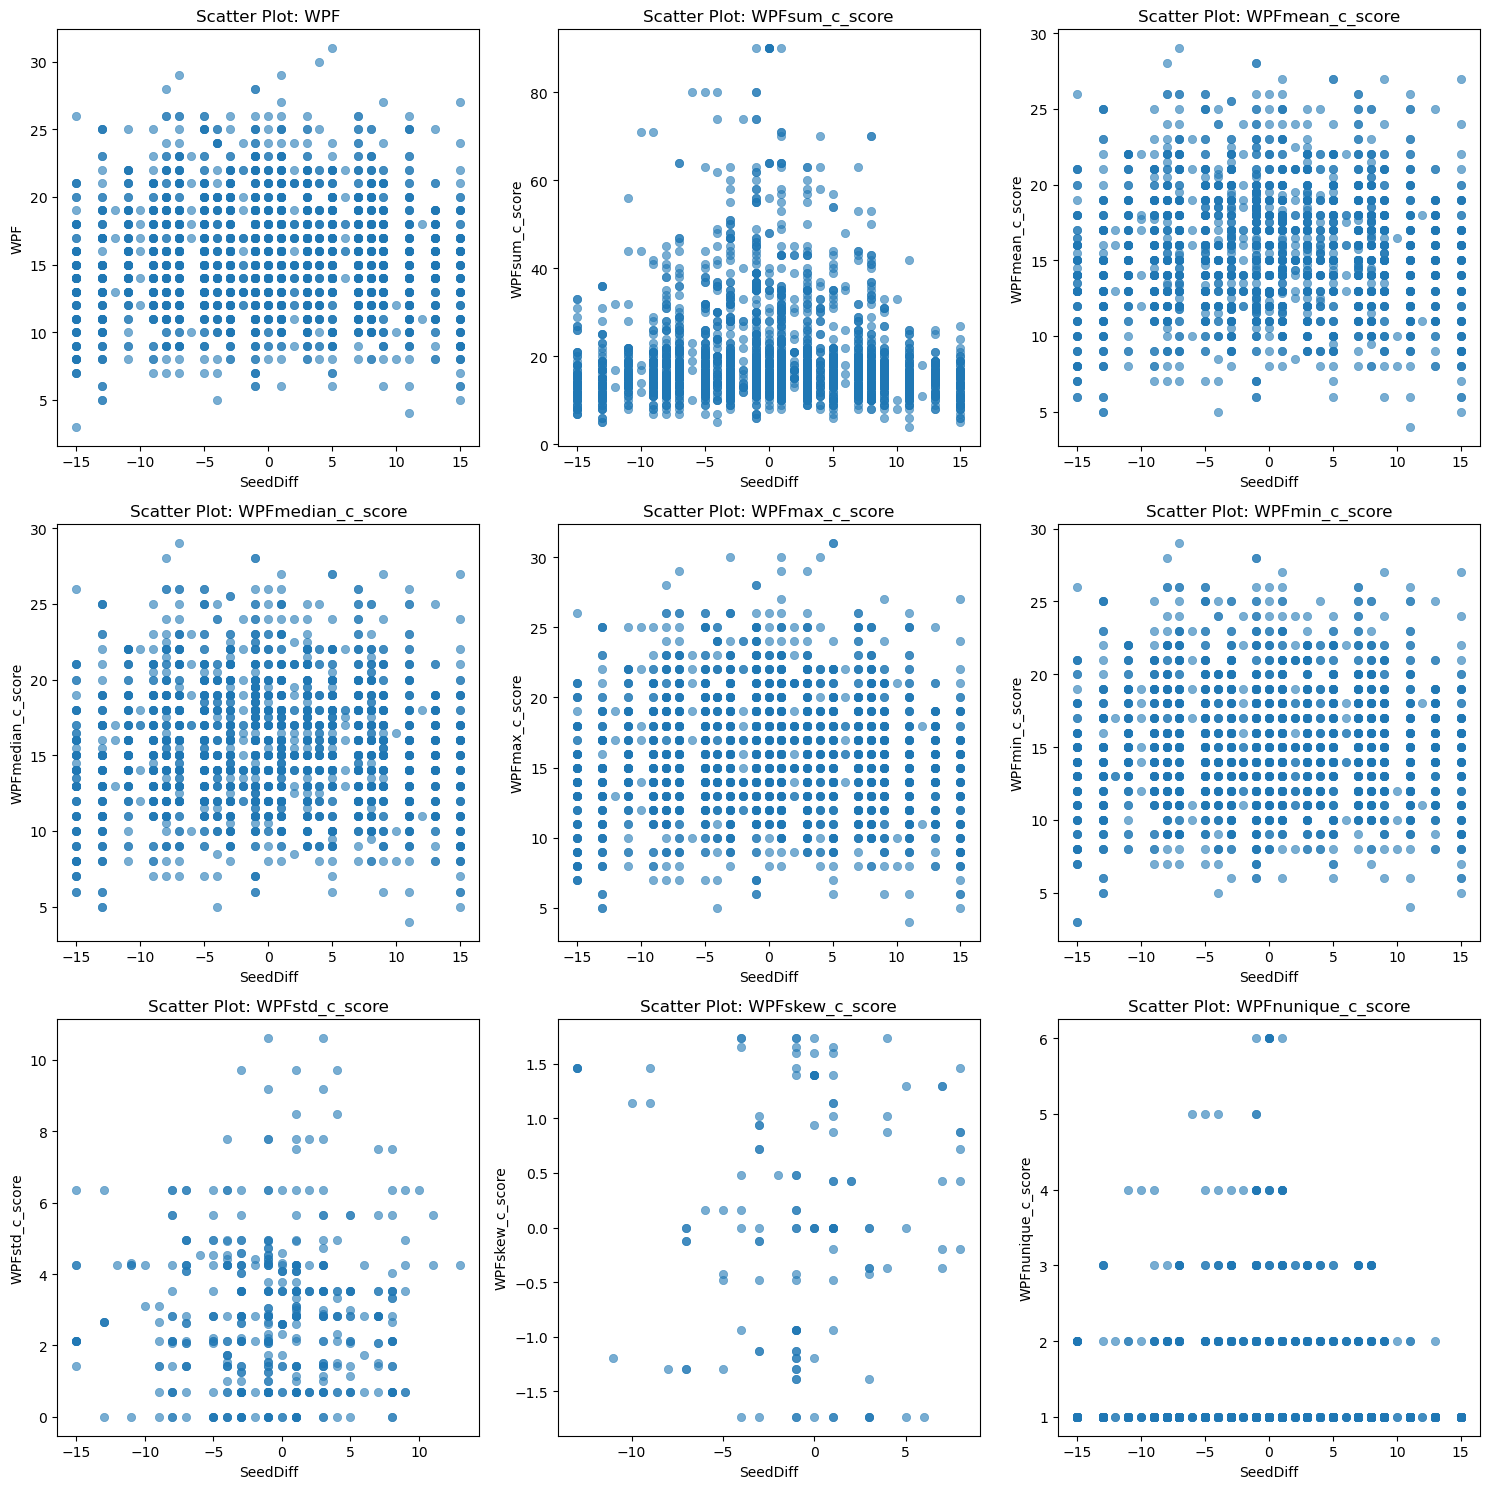

In [11]:
# Example column list
colplot = ['WPF','WPFsum_c_score', 'WPFmean_c_score', 'WPFmedian_c_score', 'WPFmax_c_score', 'WPFmin_c_score', 'WPFstd_c_score',
 'WPFskew_c_score', 'WPFnunique_c_score']

# Number of rows and columns for the grid
rows, cols = 3, 3

# Create a figure and set the size
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 3x3 grid for easy iteration

# Loop through columns and plot
for i, colnum in enumerate(colplot):
    sns.scatterplot(
        x=games['SeedDiff'],
        y=games[colnum],
        alpha=0.6,
        edgecolor=None,
        ax=axes[i]  # Pass the specific subplot to sns.scatterplot
    )
    axes[i].set_title(f"Scatter Plot: {colnum}")
    axes[i].set_xlabel("SeedDiff")
    axes[i].set_ylabel(colnum)

# Turn off empty subplots if colplot has fewer than 9 columns
for i in range(len(colplot), len(axes)):
    axes[i].axis('off')

# Adjust spacing between plots
plt.tight_layout()
plt.show()


### Baseline Model with Dummy Classifier: Majority Class and only Seed Difference as the model parameter

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, mean_absolute_error, brier_score_loss

#Define the model parameters
X = games[['SeedDiff','Season','Pred']]
y = games['Pred']

#Split the data between train and test
split_year = 2020
train = X[X['Season'] < split_year].copy()
test = X[X['Season'] >= split_year].copy()

#Split the data between train and test
X_train = train.drop(['Season','Pred'],axis = 1)
y_train = train["Pred"]

X_test = test.drop(['Season','Pred'],axis = 1)
y_test = test["Pred"]

#Define scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the DummyClassifier
baseline_majority = DummyClassifier(strategy='stratified')
baseline_majority.fit(X_train_scaled, y_train)

# Predict probabilities and class labels
pred_probs_majority = baseline_majority.predict_proba(X_test_scaled)[:, 1].clip(0.001, 0.999)
pred_majority = baseline_majority.predict(X_test_scaled)

# Calculate metrics
print(f'Majority Class Baseline - Log Loss: {log_loss(y_test, pred_probs_majority)}')
print(f'Majority Class Baseline - Mean Absolute Error: {mean_absolute_error(y_test, pred_majority)}')
print(f'Majority Class Baseline - Brier Score: {brier_score_loss(y_test, pred_probs_majority)}')

Majority Class Baseline - Log Loss: 3.695008705863129
Majority Class Baseline - Mean Absolute Error: 0.5103578154425612
Majority Class Baseline - Brier Score: 0.5337712448210924


### Baseline Model with Dummy Classifier: Most Frequent Class and only Seed Difference as the model parameter

In [13]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import log_loss, mean_absolute_error, brier_score_loss

#Define the model parameters
X = games[['SeedDiff','Season','Pred']]
y = games['Pred']

#Split the data between train and test
split_year = 2020
train = X[X['Season'] < split_year].copy()
test = X[X['Season'] >= split_year].copy()

#Split the data between train and test
X_train = train.drop(['Season','Pred'],axis = 1)
y_train = train["Pred"]

X_test = test.drop(['Season','Pred'],axis = 1)
y_test = test["Pred"]

#Define scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the DummyClassifier
baseline_majority = DummyClassifier(strategy='most_frequent')
baseline_majority.fit(X_train_scaled, y_train)

# Predict probabilities and class labels
pred_probs_majority = baseline_majority.predict_proba(X_test_scaled)[:, 1].clip(0.001, 0.999)
pred_majority = baseline_majority.predict(X_test_scaled)

# Calculate metrics
print(f'Majority Class Baseline - Log Loss: {log_loss(y_test, pred_probs_majority)}')
print(f'Majority Class Baseline - Mean Absolute Error: {mean_absolute_error(y_test, pred_majority)}')
print(f'Majority Class Baseline - Brier Score: {brier_score_loss(y_test, pred_probs_majority)}')

Majority Class Baseline - Log Loss: 3.5519309232545906
Majority Class Baseline - Mean Absolute Error: 0.5141242937853108
Majority Class Baseline - Brier Score: 0.5130970451977401


### Simple Model with only seed difference as the single feature: Logistic Regression

Accuracy: 0.72
Precision: 0.72
Recall: 0.75
F1-score: 0.73
Log Loss: 0.55
Logistic Regression: Single Feature DiffSeed - Log Loss: 0.55
Logistic Regression: Single Feature DiffSeed - Mean Absolute Error: 0.28
Logistic Regression: Single Feature DiffSeed - Brier Score: 0.19


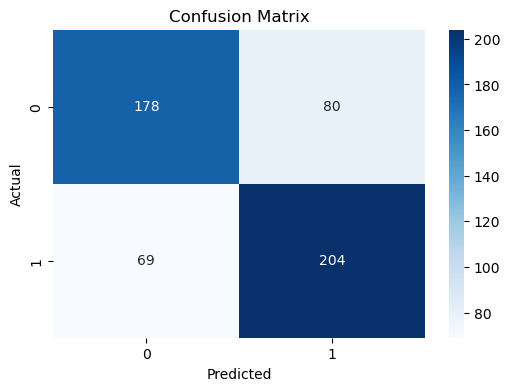

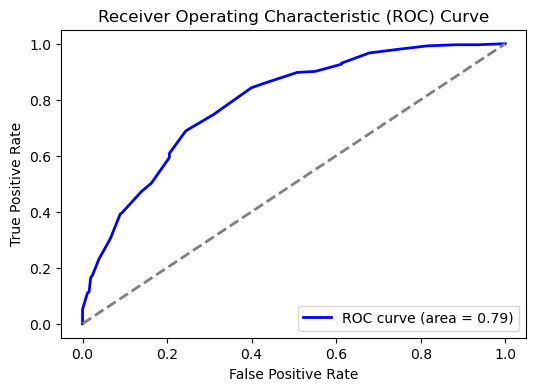

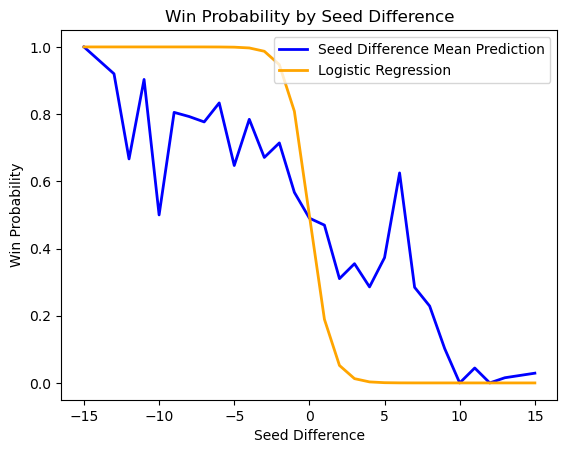

In [14]:

X = games[['SeedDiff','Season','Pred']]
y = games['Pred']

split_year = 2020
train = X[X['Season'] < split_year].copy()
test = X[X['Season'] >= split_year].copy()

X_train = train.drop(['Season','Pred'],axis = 1)
y_train = train["Pred"]

X_test = test.drop(['Season','Pred'],axis = 1)
y_test = test["Pred"]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Model: Initialize and train logistic regression model 
logreg_model = LogisticRegression()
#logreg_model = LogisticRegression(C=0.01, max_iter=100, penalty='l1', solver='liblinear')
logreg_model.fit(X_train_scaled,y_train)

# Make predictions and get probabilities
y_pred = logreg_model.predict(X_test_scaled)
pred_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
log_loss_value = log_loss(y_test, pred_prob)
mse = mean_absolute_error(y_test, y_pred)
brier_score = brier_score_loss(y_test, pred_prob)
# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Log Loss: {log_loss_value:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Log Loss: {log_loss_value:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Mean Absolute Error: {mse:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Brier Score: {brier_score:.2f}')


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot logistic curve
seed_prob = X.groupby('SeedDiff', as_index=False)['Pred'].mean()
seed_prob.plot(x='SeedDiff', y='Pred', label = 'Seed Difference Mean Prediction', color='blue', lw=2)# seed_df
seed_df = pd.DataFrame({'SeedDiff': pd.Series(range(-15, 16))})


logistic_probs = logreg_model.predict_proba(seed_df)[:, 1]
plt.plot(seed_df['SeedDiff'], logistic_probs, color='orange', label = 'Logistic Regression',lw=2)
plt.legend(loc="upper right")
plt.xlabel("Seed Difference")
plt.ylabel("Win Probability")
plt.title("Win Probability by Seed Difference")
plt.show()


### Hyper Parameter Tuning on Logistic Regression

Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.73
Accuracy: 0.72
Precision: 0.72
Recall: 0.75
F1-score: 0.73
Logistic Regression: Single Feature DiffSeed - Log Loss: 0.55
Logistic Regression: Single Feature DiffSeed - Mean Absolute Error: 0.28
Logistic Regression: Single Feature DiffSeed - Brier Score: 0.19


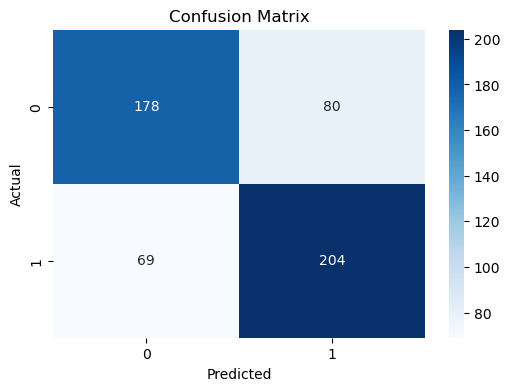

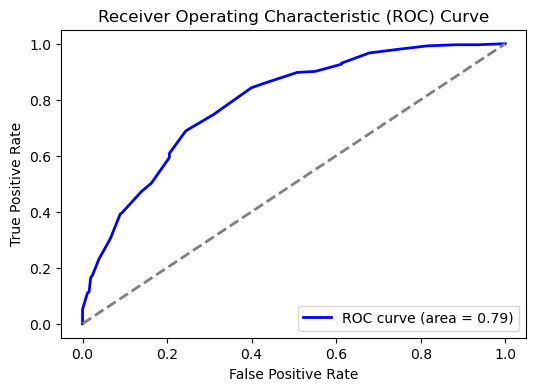

In [15]:

X = games[['SeedDiff','Season','Pred']]
y = games['Pred']

split_year = 2020
train = X[X['Season'] < split_year].copy()
test = X[X['Season'] >= split_year].copy()

X_train = train.drop(['Season','Pred'],axis = 1)
y_train = train["Pred"]

X_test = test.drop(['Season','Pred'],axis = 1)
y_test = test["Pred"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Model: Initialize and train logistic regression model 
# Define the model
logreg = LogisticRegression()

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f'Best Parameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_score:.2f}')

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)



# Make predictions and get probabilities
y_pred = logreg_model.predict(X_test_scaled)
pred_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
log_loss_value = log_loss(y_test, pred_prob)
mse = mean_absolute_error(y_test, y_pred)
brier_score = brier_score_loss(y_test, pred_prob)
# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Log Loss: {log_loss_value:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Mean Absolute Error: {mse:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Brier Score: {brier_score:.2f}')


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### Logistic Regression with all features

set()
Accuracy: 0.71
Precision: 0.74
Recall: 0.66
F1-score: 0.70
Log Loss: 0.57
Logistic Regression: Single Feature DiffSeed - Log Loss: 0.57
Logistic Regression: Single Feature DiffSeed - Mean Absolute Error: 0.29
Logistic Regression: Single Feature DiffSeed - Brier Score: 0.19


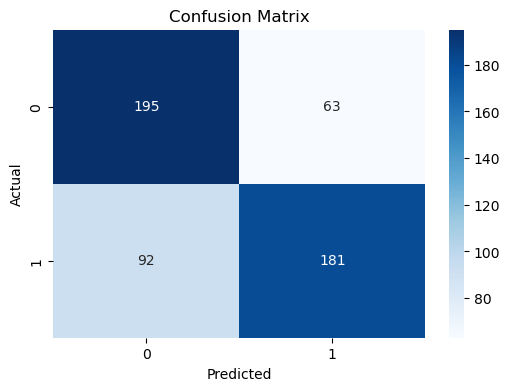

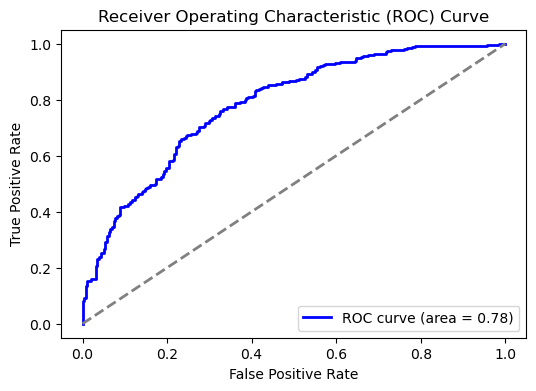

In [16]:
# col_2_removed = ['ID','WTeamID','LTeamID','WScore','LScore', 'Team1','Team2','IDTeam1','IDTeam2','ScoreDiff','ScoreDiffNorm','IDTeams']
# X = games.drop(columns=col_2_removed)
# y = games['Pred']

X = games[col+['Pred']].fillna(-1)
#X = games[col+['Pred']]

# X = X.drop(['IDTeams_c_score'], axis = 1)

missing_cols = set(col) - set(sub.columns)
print(missing_cols)
for c in missing_cols:
    sub[c] = 0

split_year = 2020
train = X[X['Season'] < split_year].copy()
test = X[X['Season'] >= split_year].copy()

X_train = train.drop('Pred',axis = 1)
y_train = train["Pred"]

X_test = test.drop('Pred',axis = 1)
y_test = test["Pred"]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Model: Initialize and train logistic regression model 
logreg_model = LogisticRegression()
logreg_model.fit(X_train_scaled,y_train)

# Make predictions and get probabilities
y_pred = logreg_model.predict(X_test_scaled)
pred_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Make predictions and get probabilities
y_pred = logreg_model.predict(X_test_scaled)
pred_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
log_loss_value = log_loss(y_test, pred_prob)
mse = mean_absolute_error(y_test, y_pred)
brier_score = brier_score_loss(y_test, pred_prob)
# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Log Loss: {log_loss_value:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Log Loss: {log_loss_value:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Mean Absolute Error: {mse:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Brier Score: {brier_score:.2f}')


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



### Logistic Regression with all features with complete dataset

set()
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1-score: 0.75
Log Loss: 0.50
Logistic Regression: Single Feature DiffSeed - Log Loss: 0.50
Logistic Regression: Single Feature DiffSeed - Mean Absolute Error: 0.25
Logistic Regression: Single Feature DiffSeed - Brier Score: 0.17


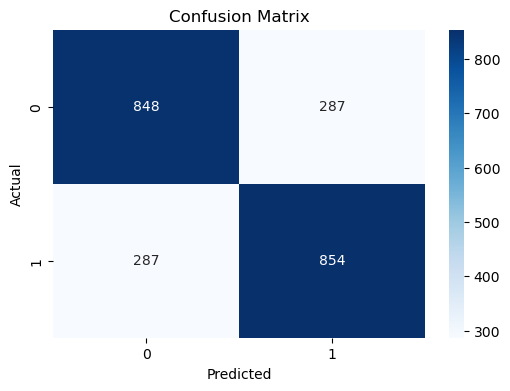

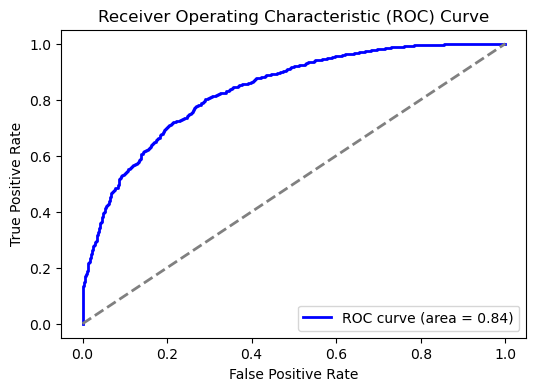

In [17]:
X = games[col+['Pred']].fillna(-1)
#X = games[col+['Pred']]

# X = X.drop(['IDTeams_c_score'], axis = 1)

missing_cols = set(col) - set(sub.columns)
print(missing_cols)
for c in missing_cols:
    sub[c] = 0

# split_year = 2020
# train = X[X['Season'] < split_year].copy()
# test = X[X['Season'] >= split_year].copy()

train = X
test = X

X_train = train.drop('Pred',axis = 1)
y_train = train["Pred"]

X_test = test.drop('Pred',axis = 1)
y_test = test["Pred"]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Model: Initialize and train logistic regression model 
logreg_model = LogisticRegression()
logreg_model.fit(X_train_scaled,y_train)

# Make predictions and get probabilities
y_pred = logreg_model.predict(X_test_scaled)
pred_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Make predictions and get probabilities
y_pred = logreg_model.predict(X_test_scaled)
pred_prob = logreg_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
log_loss_value = log_loss(y_test, pred_prob)
mse = mean_absolute_error(y_test, y_pred)
brier_score = brier_score_loss(y_test, pred_prob)
# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')
print(f'Log Loss: {log_loss_value:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Log Loss: {log_loss_value:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Mean Absolute Error: {mse:.2f}')
print(f'Logistic Regression: Single Feature DiffSeed - Brier Score: {brier_score:.2f}')


# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### XGBoost Regressor

In [18]:
#X = games[col].fillna(-1)
X = games[col]
imputer = SimpleImputer(strategy='mean')  

missing_cols = set(col) - set(sub.columns)
for c in missing_cols:
    sub[c] = 0


scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)


In [19]:
xgb = XGBRegressor(n_estimators=5000,device="gpu", learning_rate=0.03, max_depth=6, random_state=42)
xgb.fit(X_scaled, games['Pred'])

pred = xgb.predict(X_scaled).clip(0.001, 0.999)

print(f'Log Loss: {log_loss(games['Pred'], pred)}')
print(f'Mean Absolute Error: {mean_absolute_error(games['Pred'], pred)}')
print(f'Brier Score: {brier_score_loss(games['Pred'], pred)}')

cv_scores = cross_val_score(xgb, X_scaled, games['Pred'], cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean()}')


Log Loss: 0.0016798022850347076
Mean Absolute Error: 0.0016768605502830534
Brier Score: 5.861420340025088e-06
Cross-validated MSE: 0.19920195431184934


### XGBoost Classifier

In [20]:
from xgboost import XGBClassifier

# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBClassifier

# param_grid = {
#     'n_estimators': [3000, 5000],
#     'learning_rate': [0.01, 0.03],
#     'max_depth': [4, 6],
#     'min_child_weight': [1, 3],
# }

# grid_search = GridSearchCV(
#     estimator=XGBClassifier(random_state=42, device="gpu"),
#     param_grid=param_grid,
#     scoring='accuracy',
#     cv=3,
#     verbose=1
# )

# grid_search.fit(X_scaled, games['Pred'])  # Assuming you have X_train and y_train ready
# print(grid_search.best_params_)
# print(grid_search.best_score_)


In [21]:

# # Initialize the XGBClassifier
# xgb_class = XGBClassifier(n_estimators=3000, device="gpu", learning_rate=0.01, max_depth=4, random_state=42)
# xgb_class.fit(X_scaled, games['Pred'])

# # Predict probabilities for the positive class
# pred_probs = xgb_class.predict_proba(X_scaled)[:, 1].clip(0.001, 0.999)
# pred = (pred_probs > 0.5).astype(int)  # Optional: Convert probabilities to class labels

# # Calculate metrics
# print(f'Log Loss: {log_loss(games['Pred'], pred_probs)}')
# print(f'Mean Absolute Error: {mean_absolute_error(games['Pred'], pred)}')
# print(f'Brier Score: {brier_score_loss(games['Pred'], pred_probs)}')

# # Cross-validated Mean Squared Error
# cv_scores = cross_val_score(xgb, X_scaled, games['Pred'], cv=5, scoring='neg_mean_squared_error')
# print(f'Cross-validated MSE: {-cv_scores.mean()}')

In [22]:

# Initialize the XGBClassifier
xgb_class = XGBClassifier(n_estimators=5000, device="gpu", learning_rate=0.03, max_depth=6, random_state=42)
xgb_class.fit(X_scaled, games['Pred'])

# Predict probabilities for the positive class
pred_probs = xgb_class.predict_proba(X_scaled)[:, 1].clip(0.001, 0.999)
pred = (pred_probs > 0.5).astype(int)  # Optional: Convert probabilities to class labels

# Calculate metrics
print(f'Log Loss: {log_loss(games['Pred'], pred_probs)}')
print(f'Mean Absolute Error: {mean_absolute_error(games['Pred'], pred)}')
print(f'Brier Score: {brier_score_loss(games['Pred'], pred_probs)}')

# Cross-validated Mean Squared Error
cv_scores = cross_val_score(xgb, X_scaled, games['Pred'], cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean()}')

Log Loss: 0.005675858288162918
Mean Absolute Error: 0.0
Brier Score: 0.00011396644872686415
Cross-validated MSE: 0.19920195431184934


### Artificial Neural Network

In [23]:
# Function to create a fully connected neural network model for SciKeras
from scikeras.wrappers import KerasRegressor

def create_model(optimizer='adam', neurons=50, activation='relu'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(neurons, activation=activation, input_shape=(223,)))  # input_dim = 224
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasRegressor(model=create_model, verbose=2)

# Hyperparameters to be optimized
param_grid = {
    'model__neurons': [10, 25, 50, 100],
    'model__activation': ['relu', 'sigmoid'],
    'model__optimizer': ['adam', 'sgd'],
    'batch_size': [1, 10],
    'epochs': [10, 20]
}

# GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=2)
grid_result = grid.fit(X_scaled, games['Pred'])

# Display the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Epoch 1/10
1517/1517 - 4s - 3ms/step - accuracy: 0.6381 - loss: 0.6246
Epoch 2/10
1517/1517 - 3s - 2ms/step - accuracy: 0.7284 - loss: 0.4839
Epoch 3/10
1517/1517 - 3s - 2ms/step - accuracy: 0.7620 - loss: 0.4497
Epoch 4/10
1517/1517 - 3s - 2ms/step - accuracy: 0.7640 - loss: 0.4523
Epoch 5/10
1517/1517 - 3s - 2ms/step - accuracy: 0.7844 - loss: 0.4213
Epoch 6/10
1517/1517 - 3s - 2ms/step - accuracy: 0.7785 - loss: 0.4102
Epoch 7/10
1517/1517 - 3s - 2ms/step - accuracy: 0.7858 - loss: 0.4119
Epoch 8/10
1517/1517 - 3s - 2ms/step - accuracy: 0.7904 - loss: 0.4034
Epoch 9/10
1517/1517 - 3s - 2ms/step - accuracy: 0.7884 - loss: 0.3923
Epoch 10/10
1517/1517 - 3s - 2ms/step - accuracy: 0.8029 - loss: 0.3884
759/759 - 1s - 1ms/step
[CV] END batch_size=1, epochs=10, model__activation=relu, model__neurons=10, model__optimizer=adam; total time=  35.6s
Epoch 1/10
1517/1517 - 4s - 3ms/step - accuracy: 0.6842 - loss: 0.6141
Epoch 2/10
15

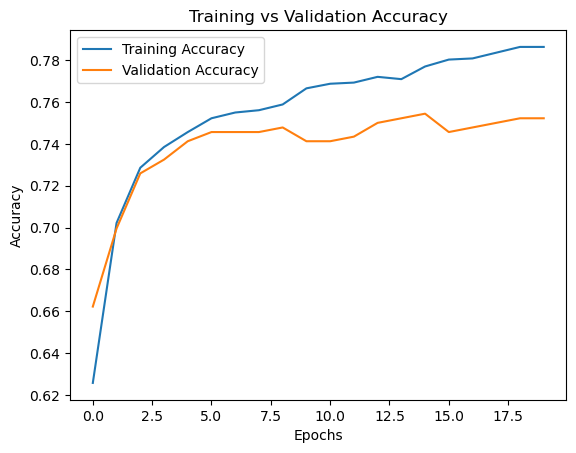

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  
Log Loss: 0.41924295661406563
Mean Absolute Error: 0.2861380717368121
Brier Score: 0.1382489042770424


In [37]:

tf.random.set_seed(42)

# Define the model with provided parameters
ANN1_model = Sequential([
    Dense(50, activation='relu', input_shape=(223,)),  # 50 neurons, 'relu' activation
    Dense(1, activation='sigmoid')  # Single output node for binary classification
])

# Compile the model with the 'sgd' optimizer
ANN1_model.compile(optimizer='sgd',  # Stochastic Gradient Descent
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Fit the model using batch_size=10 and epochs=10
model_fit = ANN1_model.fit(
    X_scaled,
    games['Pred'],
    epochs=20,               # From best parameters
    batch_size=10,           # From best parameters
    verbose=0,
    validation_split=0.2     # Keeps 20% of data for validation
)


# Plot training vs validation accuracy
plt.plot(model_fit.history['accuracy'], label='Training Accuracy')
plt.plot(model_fit.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

pred_ANN = ANN1_model.predict(X_scaled).flatten()

# Calculate metrics
print(f'Log Loss: {log_loss(games['Pred'], pred_ANN)}')
print(f'Mean Absolute Error: {mean_absolute_error(games['Pred'], pred_ANN)}')
print(f'Brier Score: {brier_score_loss(games['Pred'], pred_ANN)}')

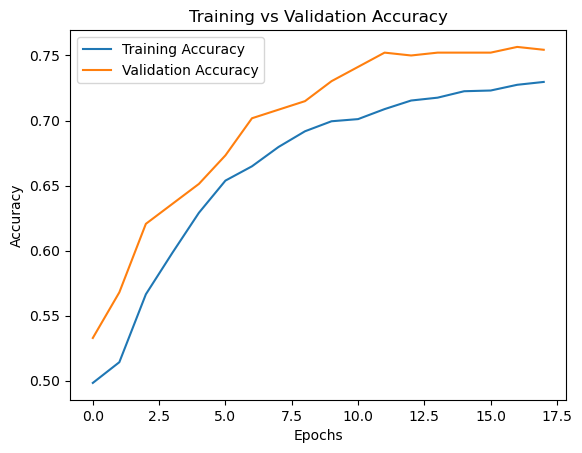

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Log Loss: 0.5523733930662998
Mean Absolute Error: 0.40406315857528174
Brier Score: 0.18415358314521849


In [38]:

tf.random.set_seed(42)

# Define the model with provided parameters
ANN2_model = Sequential([
    Dense(8, activation='relu', input_shape=(223,)),  # 10 neurons, 'relu' activation
    Dense(4, activation='sigmoid'),  # Single output node for binary classification
    Dense(1, activation='sigmoid')  # Single output node for binary classification
])

# Compile the model with the 'sgd' optimizer
ANN2_model.compile(optimizer='sgd',  # Stochastic Gradient Descent
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

# Fit the model using batch_size=10 and epochs=10
model_fit = ANN2_model.fit(
    X_scaled,
    games['Pred'],
    epochs=18,               # From best parameters
    batch_size=10,           # From best parameters
    verbose=0,
    validation_split=0.2     # Keeps 20% of data for validation
)


# Plot training vs validation accuracy
plt.plot(model_fit.history['accuracy'], label='Training Accuracy')
plt.plot(model_fit.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

pred_ANN = ANN2_model.predict(X_scaled).flatten()

# Calculate metrics
print(f'Log Loss: {log_loss(games['Pred'], pred_ANN)}')
print(f'Mean Absolute Error: {mean_absolute_error(games['Pred'], pred_ANN)}')
print(f'Brier Score: {brier_score_loss(games['Pred'], pred_ANN)}')

### Save to Submission file

In [27]:
#sub_X = sub[col].fillna(-1)
sub_X = sub[col]
sub_X_imputed = imputer.transform(sub_X)
sub_X_scaled = scaler.transform(sub_X_imputed)

sub['Pred'] = xgb.predict(sub_X_scaled).clip(0.001, 0.999)
sub[['ID', 'Pred']].to_csv('2025_sub_XGBReg.csv', index=False)

sub['Pred'] = xgb_class.predict(sub_X_scaled).clip(0.001, 0.999)
sub[['ID', 'Pred']].to_csv('2025_sub_XGBClass_Predict.csv', index=False)

sub['Pred'] = xgb_class.predict_proba(sub_X_scaled)[:, 1]
sub[['ID', 'Pred']].to_csv('2025_sub_XGB_Class_Proba.csv', index=False)

sub['Pred'] = logreg_model.predict_proba(sub_X_scaled)[:, 1]
sub[['ID', 'Pred']].to_csv('2025_sub_LogReg.csv', index=False)

sub['Pred'] = ANN1_model.predict(sub_X_scaled)
sub[['ID', 'Pred']].to_csv('2025_sub_ANN.csv', index=False)

4107/4107 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


### Reference
1. https://www.kaggle.com/code/sadettinamilverdil/ncaa-basketball-predictions-with-xgboost/comments#3149801
